In [1]:
# Cargamos las librerías necesarias
%matplotlib inline
import pandas as pd

In [2]:
# Cargamos el dataset
gastos_df = pd.read_csv('../Data/gastos_abril_2023_enriquecido.csv')

## Probar un modelo supervisado

In [3]:
# convertimos los datos en numéricos para poder trabajar con modelos de ML
data = gastos_df.copy()

for i, column in enumerate(list([str(d) for d in data.dtypes])):
    if column == "object":
        # llenamos null categóricos con la moda 
        data[data.columns[i]] = data[data.columns[i]].fillna(data[data.columns[i]].mode()) 
        # asignamos typo "category" | .cat.code hace encodign de variables categóricas
        data[data.columns[i]] = data[data.columns[i]].astype("category").cat.codes 
    else:
        #llenamos null numéricos con la mediana 
        data[data.columns[i]] = data[data.columns[i]].fillna(data[data.columns[i]].median())

In [4]:
data.head()

,C B,BENEFICIARIO,RFC,FACTURAS,CONTRATO,CONCEPTO,TIPO,FDO - #OP,FECHA,IMPORTE,SHEET,DIA,MES,AÑO,BENEFICIARIO_SALES,IMPORTE_GASTO_PROMEDIO
0,111017,238,245,820,311,786,1,1025821.0,2,1054.76,2,5,4,2023,6,549201.951569
1,111017,238,245,840,311,787,1,1025821.0,2,16090.79,2,5,4,2023,6,549201.951569
2,111017,238,245,841,311,788,1,1025821.0,2,190872.18,2,5,4,2023,6,549201.951569
3,111017,238,245,842,311,787,1,1025821.0,2,174102.14,2,5,4,2023,6,549201.951569
4,111017,238,245,821,311,785,1,1025926.0,11,1054.76,2,21,4,2023,6,549201.951569


In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [6]:
# Seleccionamos nuestra variable objetivo y las variables predictoras
y = data['IMPORTE']
X = data.drop(['IMPORTE'], axis=1)

# Dividimos el dataset en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Creamos el modelo
clf = RandomForestRegressor(n_estimators=1000, max_depth=4)

In [8]:
# Entrenamos el modelo
clf.fit(X_train, y_train)

RandomForestRegressor(max_depth=4, n_estimators=1000)

In [9]:
# Revisamos el score del modelo
from sklearn.metrics import r2_score
y_pred = clf.predict(X_test) # realizamos la predicción
r2_score(y_test, y_pred)

0.10123554183709471

## Probar un modelo no supervisado

In [10]:
import gensim
from nltk.corpus import stopwords
import numpy as np
np.random.seed(2023)

In [11]:
# Creamos una función que nos permita tokenizar y limpiar el texto
def preprocess(text):
    result = []
    for token in text.split(): # tokenizamos
        if token not in stopwords.words('spanish') and len(token) > 4: # eliminamos stopwords y palabras con menos de 4 caracteres
            result.append(token)
    return result

In [12]:
process_business = [preprocess(x) for x in list(gastos_df['BENEFICIARIO'].unique())] # aplicamos la función a la columna beneficiario

In [13]:
# Construimos el diccionario utilizando gensim
dictionary = gensim.corpora.Dictionary(process_business)

In [14]:
# Filtramos los extremos del diccionario
dictionary.filter_extremes(no_below=1, no_above=0.5)

In [15]:
bow_corpus = [dictionary.doc2bow(doc) for doc in process_business] # creamos el corpus

In [16]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=10, workers=2) # entrenamos el modelo

In [17]:
# Observaciones por cluster
for idx, type_business in lda_model.print_topics(-1):
    print('Cluster: {} \nPalabras: {}\n'.format(idx, type_business))

Cluster: 0 
Palabras: 0.035*"GRUPO" + 0.018*"CONSTRUCTORA" + 0.018*"ORTIZ" + 0.012*"GUADALUPE" + 0.012*"NUEVO" + 0.012*"PROYECTOS" + 0.012*"SOLUCIONES" + 0.012*"HERNANDEZ" + 0.012*"REYNA" + 0.012*"RIVERA"

Cluster: 1 
Palabras: 0.030*"MARTINEZ" + 0.030*"SAENZ" + 0.023*"RICARDO" + 0.023*"GOMEZ" + 0.023*"CUELLAR" + 0.016*"ESCOBEDO" + 0.016*"LIZBETH" + 0.016*"SEGUROS," + 0.016*"ANTONIO" + 0.008*"PEREZ"

Cluster: 2 
Palabras: 0.039*"CONSTRUCCIONES" + 0.028*"NAVARRO" + 0.023*"HERNANDEZ" + 0.017*"DESARROLLO" + 0.017*"GONZALEZ" + 0.017*"OCHOA" + 0.012*"MANTENIMIENTO" + 0.012*"RODRIGO" + 0.012*"PEDRO" + 0.012*"JESUS"

Cluster: 3 
Palabras: 0.019*"ALBERTO" + 0.013*"CLAUDIA" + 0.013*"GONZALEZ" + 0.013*"LUEVANO" + 0.013*"CHAVARRIA" + 0.013*"SEGUROS" + 0.013*"LOPEZ" + 0.007*"MARIA" + 0.007*"ALICIA" + 0.007*"ORTEGA"

Cluster: 4 
Palabras: 0.027*"LOPEZ" + 0.020*"MONTERREY" + 0.020*"ALVAREZ" + 0.020*"ALCALA" + 0.019*"GARCIA" + 0.014*"VERONICA" + 0.014*"ARMANDO" + 0.014*"MONTERREY," + 0.007*"PEREZ" + 

In [18]:
# Creamos una función que asigne a cada nombre su cluster correspondiente
def get_max_topic(idx):
    topics = lda_model[bow_corpus[idx]]
    return max(topics, key=lambda x:x[1])[0]

In [19]:
business_cluster = {x: get_max_topic(i) for i, x in enumerate(list(gastos_df['BENEFICIARIO'].unique()))}

In [20]:
business_cluster

{'PRAXAIR MEXICO S. DE R.L. DE C.V.': 0,
 'FUMIGACIONES TECNICAS Y JARDINERIA, S.A. DE C.V.': 9,
 'TELEFONOS DE MEXICO,S.A.B DE C.V.': 9,
 'GONZALEZ GARZA ROSA LILA': 6,
 'MANTENIMIENTO ELECTRICO DE POTENCIA,S.A.DE C.V.': 2,
 'CLIMEEZ DEL NORTE,S.A.DE C.V.': 7,
 'KABLA COMERCIAL, S.A. DE C.V.': 5,
 'INTER @ ENTER COMPUTADORAS, S.A. DE C.V.': 0,
 'SOLUCIONES SEYOR, S.A. DE C.V.': 0,
 'PC SERVICIOS INTEGRALES, S.A. DE C.V.': 8,
 'LIFETEC, S.A. DE C.V.': 4,
 'CAR ONE MONTERREY, S.A. DE C.V.': 4,
 'CARRIZALES GONZALEZ CONCEPCION': 8,
 'ORGANIZACION AUTOMOTRIZ MAL MART, S.A. DE C.V.': 7,
 'RODRIGUEZ VALDES RAYMUNDO': 5,
 'SWISSLAB, S.A. DE C.V.': 0,
 'EPSILON ENTERTAINMENT, S.A. DE C.V.': 5,
 'PINEDA GUERRERO OSCAR': 6,
 'TOP MEDICAL, S.A. DE C.V.': 0,
 'INDUSTRIAS SOLA BASIC, S.A. DE C.V.': 7,
 'FRANCO GARCIA MARIBEL': 6,
 'CHAPA RIOS RAUL': 5,
 'BENITES VALDES JOSE LUCIO': 5,
 'AUTO ESTETICA DAK AR, S.A. DE C.V.': 5,
 'PRONTO AUTOSERVICIO, S.A. DE C.V.': 9,
 'SUPERLLANTAS SANTO DOMINGO, S

In [21]:
gastos_df['CLUSTER_NAME'] = gastos_df['BENEFICIARIO'].map(business_cluster) # asignamos el cluster a cada observación

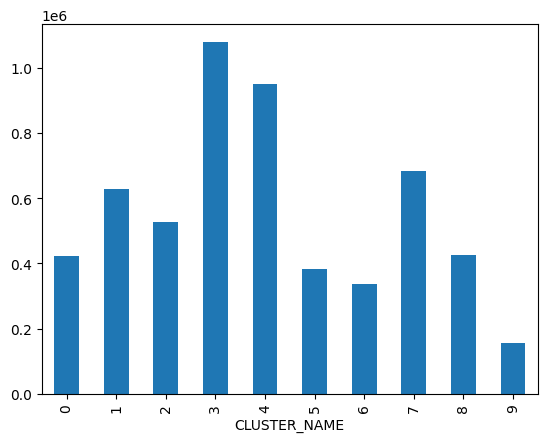

In [22]:
# creamos una gráfica de barras para visualizar los clusters
gastos_df.groupby('CLUSTER_NAME')['IMPORTE'].mean().plot(kind='bar');